# Test Code for dm_control & mujoco


In [1]:
from dm_control import mujoco
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import PIL.Image
import numpy as np

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

In [2]:
def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()

    plt.close("all")
    matplotlib.use("Agg")  # Switch to headless 'Agg' to inhibit figure rendering.

    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)

    plt.close("all")
    matplotlib.use(orig_backend)  # Switch back to the original backend.

    ax.set_axis_off()
    ax.set_aspect("equal")
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]

    interval = 1000 / framerate
    anim = animation.FuncAnimation(
        fig=fig,
        func=update,
        frames=frames,
        interval=interval,
        blit=True,
        repeat=False,
    )

    html = HTML(anim.to_html5_video())
    return html

## Example Codes


### Free Drop


(240, 320, 3)


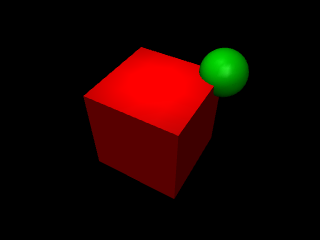

In [3]:
physics = mujoco.Physics.from_xml_path("./simple_model.xml")
pixels = physics.render()
print(pixels.shape)
PIL.Image.fromarray(pixels)

ImportError: cannot import name 'wrapper' from 'mujoco' (/home/j2y/miniconda3/envs/act/lib/python3.10/site-packages/mujoco/__init__.py)

In [4]:
duration = 10  # (seconds)
framerate = 30  # (Hz)

# Visualize the joint axis
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True

# Simulate and display video.
frames = []
physics.reset()  # Reset state and time
while physics.data.time < duration:
    physics.step()
    if len(frames) < physics.data.time * framerate:
        pixels = physics.render(scene_option=scene_option)
        frames.append(pixels)
display_video(frames, framerate)

### Tippe-Top


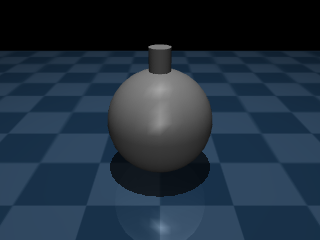

In [5]:
physics = mujoco.Physics.from_xml_path("./tippe_top.xml")
PIL.Image.fromarray(physics.render(camera_id="closeup"))

In [6]:
duration = 10
framerate = 60
time_vals = []
angular_velocity = []
stem_height = []
frames = []

physics.reset(0)
while physics.data.time < duration:
    physics.step()
    time_vals.append(physics.data.time)
    angular_velocity.append(physics.data.qvel[3:6].copy())
    stem_height.append(physics.named.data.geom_xpos["stem", "z"])
    if len(frames) < (physics.data.time) * framerate:
        pixels = physics.render(camera_id="closeup")
        frames.append(pixels)

display_video(frames, framerate=framerate)

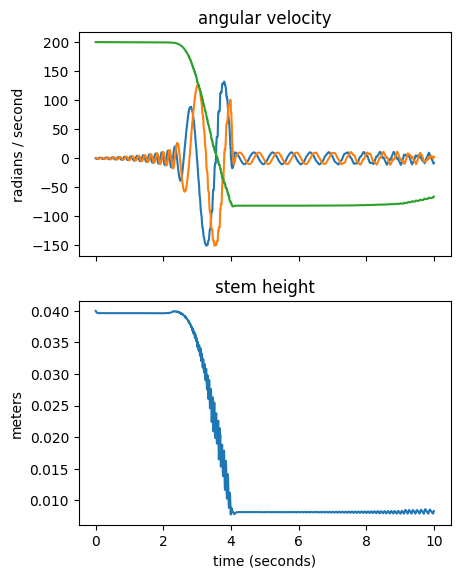

In [7]:
# draw graph
# %config InlineBackend.figure_format = 'svg'
%matplotlib inline

dpi = 100
width = 480
height = 640
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=100, sharex=True)

ax[0].plot(time_vals, angular_velocity)
ax[0].set_title("angular velocity")
ax[0].set_ylabel("radians / second")

ax[1].plot(time_vals, stem_height)
ax[1].set_xlabel("time (seconds)")
ax[1].set_ylabel("meters")
_ = ax[1].set_title("stem height")

### PyMJCF


In [8]:
from dm_control import mjcf


class Leg:
    def __init__(self, length, rgba):
        super().__init__()
        self.model = mjcf.RootElement()
        # defaults
        self.model.default.joint.damping = 2
        self.model.default.joint.type = "hinge"
        self.model.default.geom.type = "capsule"
        self.model.default.geom.rgba = rgba

        # Thigh
        self.thigh = self.model.worldbody.add("body")
        self.hip = self.thigh.add("joint", axis=[0, 0, 1])
        self.thigh.add("geom", fromto=[0, 0, 0, length, 0, 0], size=[length / 4])

        # Hip
        self.shin = self.thigh.add("body", pos=[length, 0, 0])
        self.knee = self.shin.add("joint", axis=[0, 1, 0])
        self.shin.add("geom", fromto=[0, 0, 0, 0, 0, -length], size=[length / 5])

        # position actuators
        self.model.actuator.add("position", joint=self.hip, kp=10)
        self.model.actuator.add("position", joint=self.knee, kp=10)

In [9]:
BODY_RADIUS = 0.1
BODY_SIZE = (BODY_RADIUS, BODY_RADIUS, BODY_RADIUS / 2)
random_state = np.random.RandomState()


def make_creature(num_legs):
    rgba = random_state.uniform([0, 0, 0, 1], [1, 1, 1, 1])
    model = mjcf.RootElement()
    model.compiler.angle = "radian"
    # torso geom
    model.worldbody.add(
        "geom", name="torso", type="ellipsoid", size=BODY_SIZE, rgba=rgba
    )
    # Attach legs to equidistant sites on the circumference
    for i in range(num_legs):
        theta = 2 * i * np.pi / num_legs
        hip_pos = BODY_RADIUS * np.array([np.cos(theta), np.sin(theta), 0])
        hip_site = model.worldbody.add("site", pos=hip_pos, euler=[0, 0, theta])
        leg = Leg(length=BODY_RADIUS, rgba=rgba)
        hip_site.attach(leg.model)

    return model

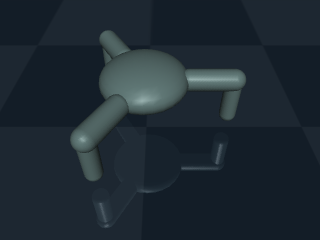

In [10]:
arena = mjcf.RootElement()
chequered = arena.asset.add(
    "texture",
    type="2d",
    builtin="checker",
    width=300,
    height=300,
    rgb1=[0.2, 0.3, 0.4],
    rgb2=[0.3, 0.4, 0.5],
)

grid = arena.asset.add(
    "material", name="grid", texture=chequered, texrepeat=[5, 5], reflectance=0.2
)
arena.worldbody.add("geom", type="plane", size=[2, 2, 0.1], material=grid)
for x in [-2, 2]:
    arena.worldbody.add("light", pos=[x, -1, 3], dir=[x, 1, -2])


creatures = [make_creature(num_legs=num_legs) for num_legs in range(3, 9)]
model = creatures[0]
spawn_site = arena.worldbody.add("site", pos=[0, 0, 0.15])
spawn_site.attach(model).add("freejoint")

physics = mjcf.Physics.from_mjcf_model(arena)
PIL.Image.fromarray(physics.render())